In [1]:
from pnca import ProxyNCA
import torchvision.models
import torch
from torch.autograd import Variable
from torchvision import datasets, transforms
import numpy as np
import time
import matplotlib.pyplot as plt
import data

# 1. Training

In [3]:
sz_batch = 32
sz_embed = 64
nb_classes = 100 // 2

In [4]:
cub = torch.utils.data.DataLoader(
    data.Birds(path = 'cub200/images', label_range = [0, nb_classes]),
    batch_size = sz_batch,
    shuffle = True,
    num_workers = 4
)

In [12]:
inception = torchvision.models.inception_v3(pretrained=True)

In [13]:
model = ProxyNCA(inception, sz_embed, nb_classes, sz_batch)
model.cuda()
print()

In [ ]:
t1 = time.time()
opt = torch.optim.Adam(model.parameters(), lr=0.001)
nb_epochs = 100 # 7 * 60 * 60 / 70 = 360

In [ ]:
print("Training for {} epochs.".format(nb_epochs))

losses = []

for e in range(1, nb_epochs + 1):
    time_per_epoch_1 = time.time()
    for x, y in cub:
        # *model depends on batch size, at end of epoch, batch_size is uneven!
        # alternatively: drop_last = True?
        if y.shape[0] != sz_batch:
            continue
        opt.zero_grad()
        loss = model(Variable(x).cuda(), Variable(y).cuda())
        loss.backward()
        opt.step()
    time_per_epoch_2 = time.time()
    losses.append(loss.data.cpu().numpy()[0])
    print(
        "Epoch: {}, loss: {}, time (seconds): {:.2f}.".format(
            e, 
            losses[-1],
            time_per_epoch_2 - time_per_epoch_1
        )
    )

t2 = time.time()
print("Total training time (minutes): {:.2f}.".format((t2 - t1) / 60))

Training for 100 epochs.
Epoch: 1, loss: 3.413837432861328, time (seconds): 120.57.
Epoch: 2, loss: 2.9300901889801025, time (seconds): 121.89.
Epoch: 4, loss: 2.7094390392303467, time (seconds): 122.13.
Epoch: 5, loss: 2.5598316192626953, time (seconds): 120.38.


In [22]:
torch.save(model, 'cub-{}-classes-{}-epochs.pt'.format(nb_classes, nb_epochs))

In [20]:
np.save("cub-losses.npy", losses)

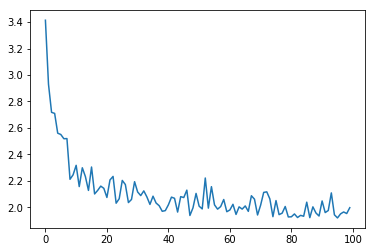

In [21]:
losses = np.load("cub-losses.npy")
plt.plot(losses)
plt.show()

# 2. Inference & Evaluation

## 2.1 Loading Data, Model and Predicting

In [11]:
model = torch.load('cub-50-classes-100-epochs.pt')

In [12]:
nb_classes = 200 // 2

In [13]:
cub_tr = torch.utils.data.DataLoader(
    # load classes 0 to 100
    data.Birds(path = 'cub200/images', label_range = [0, nb_classes]), 
    batch_size = 50,
    shuffle = False,
    num_workers = 4
)

In [14]:
cub_te = torch.utils.data.DataLoader(
    # load classes 100 to 200
    data.Birds(path = 'cub200/images', label_range = [200 // 2, 200 // 2 + nb_classes]),
    batch_size = 50,
    shuffle = False,
    num_workers = 4
)

In [15]:
def predict_batchwise(model, dataloader):
    # only xs are transformed to embeddings, ys are only appended
    xss = []
    yss = []
    for xs, ys in dataloader:
        for x, y in zip(model(Variable(xs, volatile = True).cuda())[0].data.cpu().numpy(), ys):
            xss.append(x)
            yss.append(y)
    return np.array(xss), np.array(yss)

In [16]:
xs_tr, ys_tr = predict_batchwise(model.no_top_model, cub_tr)
xs_te, ys_te = predict_batchwise(model.no_top_model, cub_te)

## 2.2 NMI and R@k

In [17]:
import evaluation

In [18]:
print(
    "NMI tr : {} \nNMI te : {}".format(
        evaluation.calc_nmi(ys_tr, evaluation.cluster_by_kmeans(xs_tr, nb_classes)),
        evaluation.calc_nmi(ys_te, evaluation.cluster_by_kmeans(xs_te, nb_classes))
    )
)

NMI tr : 0.3396951132786114 
NMI te : 0.25464903925305515


In [19]:
for xs, ys in [[xs_tr, ys_tr], [xs_te, ys_te]]:
    for k in [1, 2, 4, 8]:
        ys_pred_k = evaluation.assign_by_euclidian_at_k(xs, ys, k)
        r_at_k = evaluation.recall_at_k(ys, ys_pred_k, k)
        print("R@{} : {}".format(k, r_at_k))

R@1 : 0.11471571906354515
R@2 : 0.17625418060200668
R@4 : 0.24983277591973244
R@8 : 0.3347826086956522
R@1 : 0.017745645744331254
R@2 : 0.046007229707525465
R@4 : 0.08281301347354585
R@8 : 0.14262241209332896


In [20]:
ys_pred_k[:10], ys[:10]

(array([[69, 78, 21,  4, 98,  2, 54, 49],
        [ 5,  5, 82, 14, 28, 80, 73, 10],
        [30, 10, 31, 65, 81, 19, 43,  0],
        [40, 42, 19,  8, 90,  0, 90, 97],
        [45, 74, 58, 77, 33, 86, 87,  9],
        [37, 68, 21, 36, 61, 57, 57, 91],
        [40, 22,  5, 72, 29, 40, 38, 87],
        [50, 53, 80, 58, 21, 50, 80, 77],
        [67, 95, 12, 97, 84, 29, 29, 53],
        [12, 79, 22, 56,  1, 58, 56, 93]]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))